In [13]:
%run "libraries.ipynb"

import nltk

common libraries loaded


In [3]:
pages = codecs.open("data/pagenames.txt","r", "utf-8-sig").readlines()
pages = map(lambda x: x.strip(), pages)

In [45]:
def page_lsm_cats(page):
  page = wekeypedia.WikipediaPage(page)
  txt = page.get_revision()
  txt = BeautifulSoup(txt, "html.parser")
  txt = txt.get_text()
  txt = txt.replace("[edit]","")
  
  return extract_categories(txt)

def extract_categories(text):
  text_tagged = nltk.pos_tag(nltk.word_tokenize(text))
  
  lemmatizer = nltk.WordNetLemmatizer()
  tags = defaultdict(list)

  for (word, tag) in text_tagged:
    tags[tag].append(word)

  for i in ["''", ",", ".", "``", ":", "-NONE-"]:
    tags.pop(i, None)
  
  impersonal = ["it", "this", "that", "its", "anything" ]
  
  def get_per_pronouns(tags):
    pt = [ tags[tag] for tag in tags.keys() if tag.startswith('PRP') ]
    pt = [ p for pl in pt for p in pl ]

    return [ p for p in pt if not(p.lower() in impersonal) ] 

  def get_imp_pronouns(tags):
    pt = [ tags[tag] for tag in tags.keys() if tag.startswith('PRP') ]
    pt = [ p for pl in pt for p in pl ]

    return [ p for p in pt if p.lower() in impersonal ]     

  def get_aux_verbs(tags):
    vt = [ tags[tag] for tag in tags.keys() if tag.startswith('V') ]
    vt = [ v for vl in vt for v in vl ]

    aux_verbs = [ "be", "have", "do", "will" ]

    return [ verb for verb in vt if lemmatizer.lemmatize(verb, nltk.corpus.wordnet.VERB) in aux_verbs ]
  
  def get_hf_adverbs(tags):
    advt = tags["RB"]
    return [ w for w in advt if w.lower() in [ "often", "well", "very", "frequently", "generally" ] ]

  def get_negations(tags):
    nt = tags["RB"]
    return [ w for w in nt if w.lower() in [ "not", "no", "never" ] ]

  def get_quantifiers(tags):
    qt = [ tags[tag] for tag in ["JJ", "JJR", "DT", "PDT" ] ]
    qt = [ q for ql in qt for q in ql ]

    quants = [ "all", "any", "both", "each", "enough", "every", "few", "fewer",
              "little", "less", "lots", "many", "more", "several", "some" ]

    return [ w for w in qt if w.lower() in quants ]

  categories = {
    "personal pronouns": get_per_pronouns(tags),
    "impersonal pronouns": get_imp_pronouns(tags),
    "articles": tags["DT"],
    "auxiliary verbs": get_aux_verbs(tags),
    "hf adverbs": get_hf_adverbs(tags),
    "prepositions": tags["IN"],
    "conjunctions": tags["CC"],
    "negations": get_negations(tags),
    "quantifiers": get_quantifiers(tags),
    "total words": len(text_tagged)
  }

  return categories

In [68]:
data = defaultdict(dict)

for page in pages:
  txt = json.load(codecs.open("data/pages/%s.json" % page,"r", encoding="utf-8-sig"))
  print "\r%s" % page,
  txt = txt["query"]["pages"][ txt["query"]["pages"].keys()[0] ]["revisions"][0]["*"]
  txt = BeautifulSoup(txt, "html.parser")
  txt = txt.get_text()
  txt = txt.replace("[edit]","")

  data[page] = extract_categories(txt)

Zonohedron


In [69]:
for k1 in data.keys():    
  for k2 in [ k for k in data[k1].keys() if k != "total words" ]:
    if isinstance(data[k1][k2], list):
      data[k1][k2] = float(len(data[k1][k2]))/float(data[k1]["total words"])

df = pd.DataFrame.from_dict(data, orient="index")
# df = pd.DataFrame.from_dict({ k1: { k2: len(data[k1][k2]) for k2 in data[k1].keys() } for k1 in data.keys() }, orient="index")

print df.head(5)

                      personal pronouns  articles  hf adverbs  prepositions  \
2D computer graphics           0.003773  0.093374    0.002594      0.092667   
2D geometric model             0.010582  0.089947    0.010582      0.089947   
3-sphere                       0.008686  0.125941    0.001158      0.112044   
3D computer graphics           0.001434  0.069534    0.004301      0.092473   
3D projection                  0.003715  0.105882    0.001238      0.087926   

                      total words  impersonal pronouns  quantifiers  \
2D computer graphics         4241             0.003065     0.011082   
2D geometric model            189             0.000000     0.010582   
3-sphere                     3454             0.004922     0.008975   
3D computer graphics         1395             0.002151     0.005735   
3D projection                1615             0.003096     0.003715   

                      auxiliary verbs  negations  conjunctions  
2D computer graphics         0.03

In [71]:
df.to_csv("data/pages-lsm_categories.csv", encoding="utf8")

In [78]:
def get_lsm(df, u, v):
  cat_list = [ k for k in df.columns if not(k.startswith("total")) ]
    
  u_cat = df.ix[u].to_dict()
  v_cat = df.ix[v].to_dict()
    
  lsm = { k: 1 - abs(u_cat[k] - v_cat[k])/(u_cat[k] + v_cat[k] + 0.001) for k in cat_list }

  lsm["mean"] = np.mean(lsm.values())

  return lsm

matrix = pd.DataFrame.from_dict({ u: {v: get_lsm(df, u, v) for v in pages  } for u in pages})

In [84]:
matrix_mean = pd.DataFrame({ u: {v: matrix[u][v]["mean"] for v in pages } for u in pages})

In [89]:
matrix_mean.to_csv("data/pages-lsm_mean.csv",encoding="utf-8")

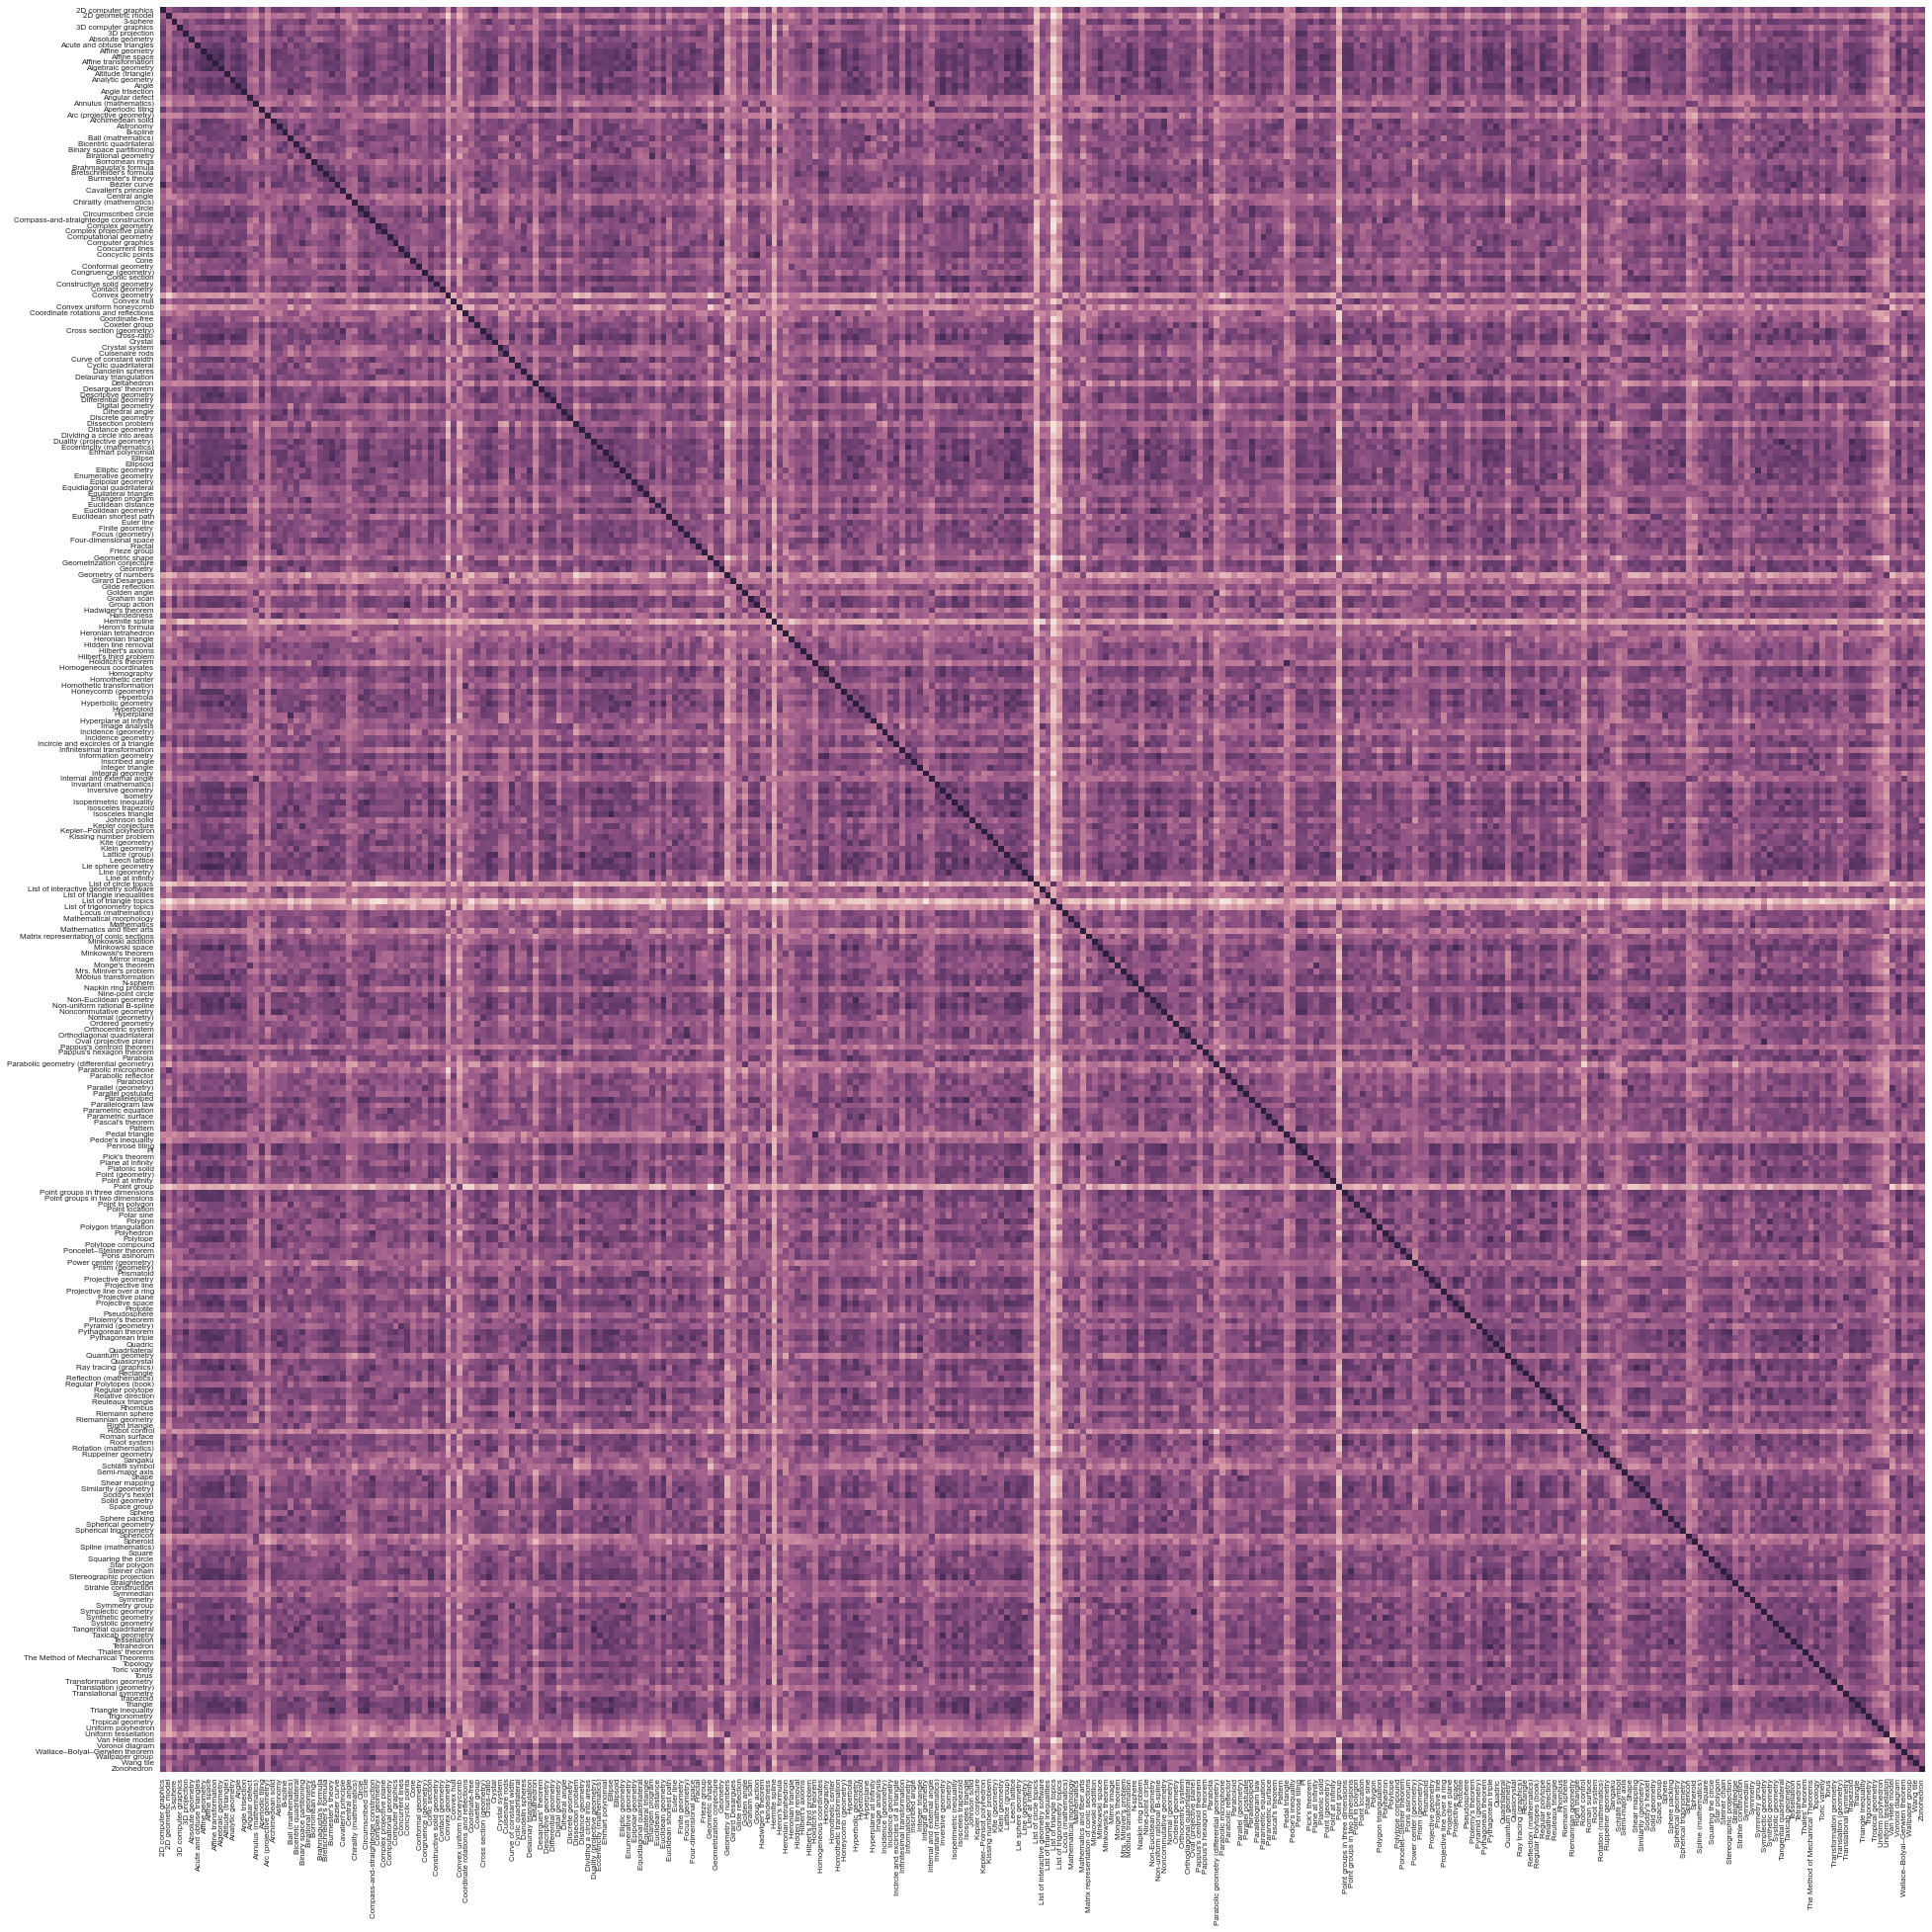

In [101]:
sns.set_context("notebook", font_scale=0.8)

f, ax = plt.subplots(figsize=(32, 32))
sns.heatmap(matrix_mean, linewidths=0, cbar=False, square=True)